## Implementation

*Python Modules*

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !rm -r /content/drive/MyDrive/data/Data

# !unzip /content/drive/MyDrive/data/Data.zip -d /content/drive/MyDrive/data

Mounted at /content/drive


In [ ]:
import os
import shutil

# Define the source directory containing the images
source_dir = '/content/drive/MyDrive/SRGAN/result'

# Define the target directories for DME and DRUSEN images
dme_dir = os.path.join(source_dir, 'generated/DME')
drusen_dir = os.path.join(source_dir, 'generated/DRUSEN')

# Create target directories if they don't exist
os.makedirs(dme_dir, exist_ok=True)
os.makedirs(drusen_dir, exist_ok=True)

# Iterate over each file in the source directory
for filename in os.listdir(source_dir):
    # Check if the file is an image with 'DME' in its name
    if 'DME' in filename and filename.endswith('.png'):
        # Move the file to the DME directory
        shutil.move(os.path.join(source_dir, filename), os.path.join(dme_dir, filename))
    # Check if the file is an image with 'DRUSEN' in its name
    elif 'DRUSEN' in filename and filename.endswith('.png'):
        # Move the file to the DRUSEN directory
        shutil.move(os.path.join(source_dir, filename), os.path.join(drusen_dir, filename))

print("Images have been successfully moved to their respective folders.")


Images have been successfully moved to their respective folders.


In [ ]:
data_dir = '/content/drive/MyDrive/SRGAN/result'
TRAIN = 'generated'
TEST = 'test_HR'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize tensor
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize tensor
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

# for x in [TRAIN, TEST]:
#     print("Loaded {} images under {}".format(dataset_sizes[x], x))

# print("Classes: ")
class_names = image_datasets[TRAIN].classes
# print(image_datasets[TRAIN].classes)

## Utils

Some utility function to visualize the dataset and the model's predictions

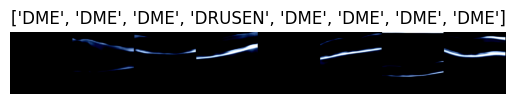

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training

    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]

        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state

This helper function will give us the accuracy of our model on the test set.

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
from torchvision import models
vgg16 = models.vgg16_bn(pretrained=True)
# vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 75.1MB/s]


1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

The output above is the summary of our model.

In [ ]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
# resume_training = True

# if resume_training:
#     print("Loading pretrained model..")
#     vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
#     print("Loaded!")

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs.


In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)


In [ ]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/444

<ipython-input-9-b1630242d162>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 400/444
Evaluation completed in 1m 57s
Avg loss (test): 0.0927
Avg acc (test): 0.3201
----------


<ipython-input-8-6591839c770f>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


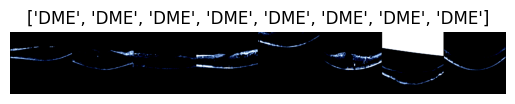

Prediction:


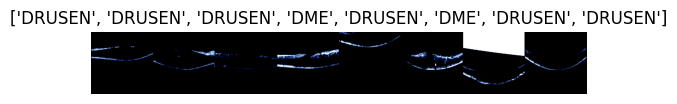

In [ ]:
visualize_model(vgg16) #test before training

## Training

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`.
Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy).
The accuracy will tell us how many predictions were correct.


In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    # avg_loss_val = 0
    # avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    # val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        # loss_val = 0
        acc_train = 0
        # acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train = loss.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        # for i, data in enumerate(dataloaders[VAL]):
        #     if i % 100 == 0:
        #         print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

        #     inputs, labels = data

        #     if use_gpu:
        #         inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        #     else:
        #         inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        #     optimizer.zero_grad()

        #     outputs = vgg(inputs)

        #     _, preds = torch.max(outputs.data, 1)
        #     loss = criterion(outputs, labels)

        #     loss_val += loss.item()
        #     acc_val += torch.sum(preds == labels.data)

        #     del inputs, labels, outputs, preds
        #     torch.cuda.empty_cache()

        # avg_loss_val = loss_val / dataset_sizes[VAL]
        # avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.7f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        # print("Avg loss (val): {:.4f}".format(avg_loss_val))
        # print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        # if avg_acc_val > best_acc:
        #     best_acc = avg_acc_val
        #     best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina_half_dataset.pt')

Epoch 0/10
----------
Training batch 500/581.0

Epoch 0 result: 
Avg loss (train): 0.0002
Avg acc (train): 0.9293
----------

Epoch 1/10
----------
Training batch 500/581.0

Epoch 1 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9383
----------

Epoch 2/10
----------
Training batch 500/581.0

Epoch 2 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9390
----------

Epoch 3/10
----------
Training batch 500/581.0

Epoch 3 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9416
----------

Epoch 4/10
----------
Training batch 500/581.0

Epoch 4 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9407
----------

Epoch 5/10
----------
Training batch 500/581.0

Epoch 5 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9433
----------

Epoch 6/10
----------
Training batch 500/581.0

Epoch 6 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9446
----------

Epoch 7/10
----------
Training batch 500/581.0

Epoch 7 result: 
Avg loss (train): 0.0000
Avg acc (train): 0.9508
----

## Model evaluation and visualization (after training)


In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/444

<ipython-input-9-b1630242d162>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 400/444
Evaluation completed in 0m 34s
Avg loss (test): 0.0927
Avg acc (test): 0.3201
----------


<ipython-input-8-6591839c770f>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


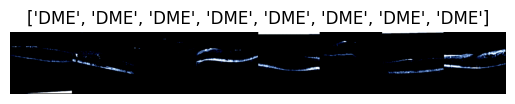

Prediction:


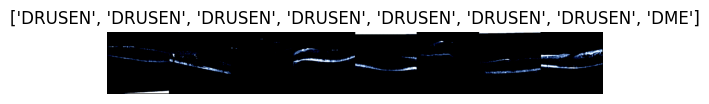

Ground truth:


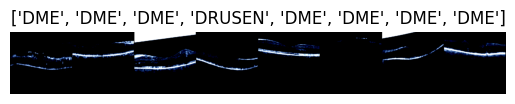

Prediction:


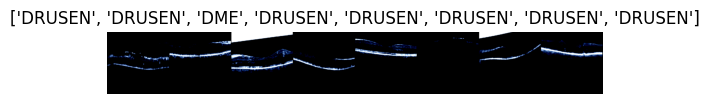

Ground truth:


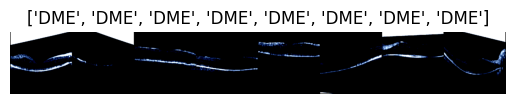

Prediction:


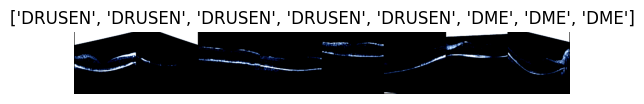

Ground truth:


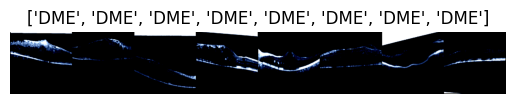

Prediction:


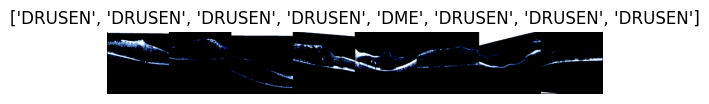

In [ ]:
visualize_model(vgg16, num_images=32)

In [ ]:
!mv /content/VGG16_v2-OCT_Retina_half_dataset.pt /content/drive/MyDrive/SRGAN/Model_B